Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta1, beta2, beta3, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.


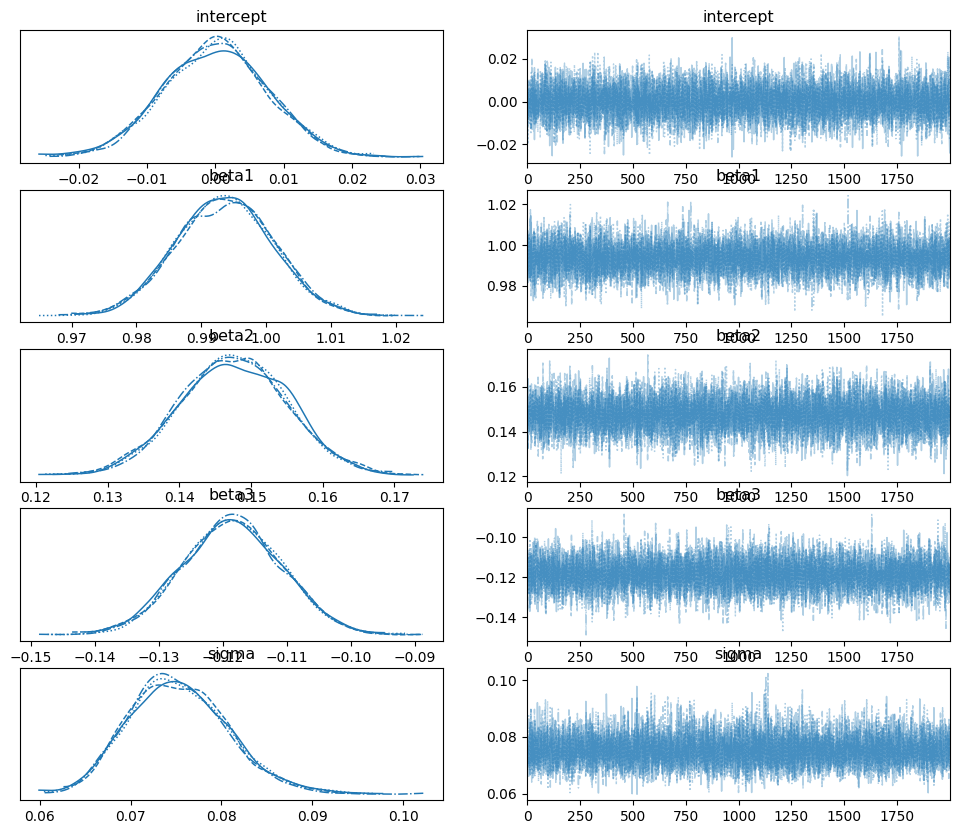

            mean     sd  hdi_3%  hdi_97%
intercept  0.000  0.008  -0.014    0.014
beta1      0.994  0.008   0.979    1.008
beta2      0.148  0.008   0.133    0.161
beta3     -0.119  0.008  -0.133   -0.104
sigma      0.075  0.005   0.066    0.086


In [8]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

# citesc datele din fisierul csv
file_path = 'real_estate_data.csv'
data = pd.read_csv(file_path)

# prelucrez datele
x1 = data['Surface_area'].values
x2 = data['Rooms'].values
x3 = data['Distance_to_center'].values
y = data['Price'].values #dependenta

# normalizarea datelor => variabilele se transforma astfel incat: media =0, deviatia standard 1
x1_norm = (x1 - x1.mean()) / x1.std()
x2_norm = (x2 - x2.mean()) / x2.std()
x3_norm = (x3 - x3.mean()) / x3.std()
y_norm = (y - y.mean()) / y.std()


with pm.Model() as model:
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    beta1 = pm.Normal("beta1", mu=0, sigma=1)
    beta2 = pm.Normal("beta2", mu=0, sigma=1)
    beta3 = pm.Normal("beta3", mu=0, sigma=1) #beta= coeficienti pt variabile independente
    
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    mu = intercept + beta1 * x1_norm + beta2 * x2_norm + beta3 * x3_norm
    
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_norm)
    
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)
    
az.plot_trace(trace)
plt.show()

summary = az.summary(trace, kind="stats")
print(summary)



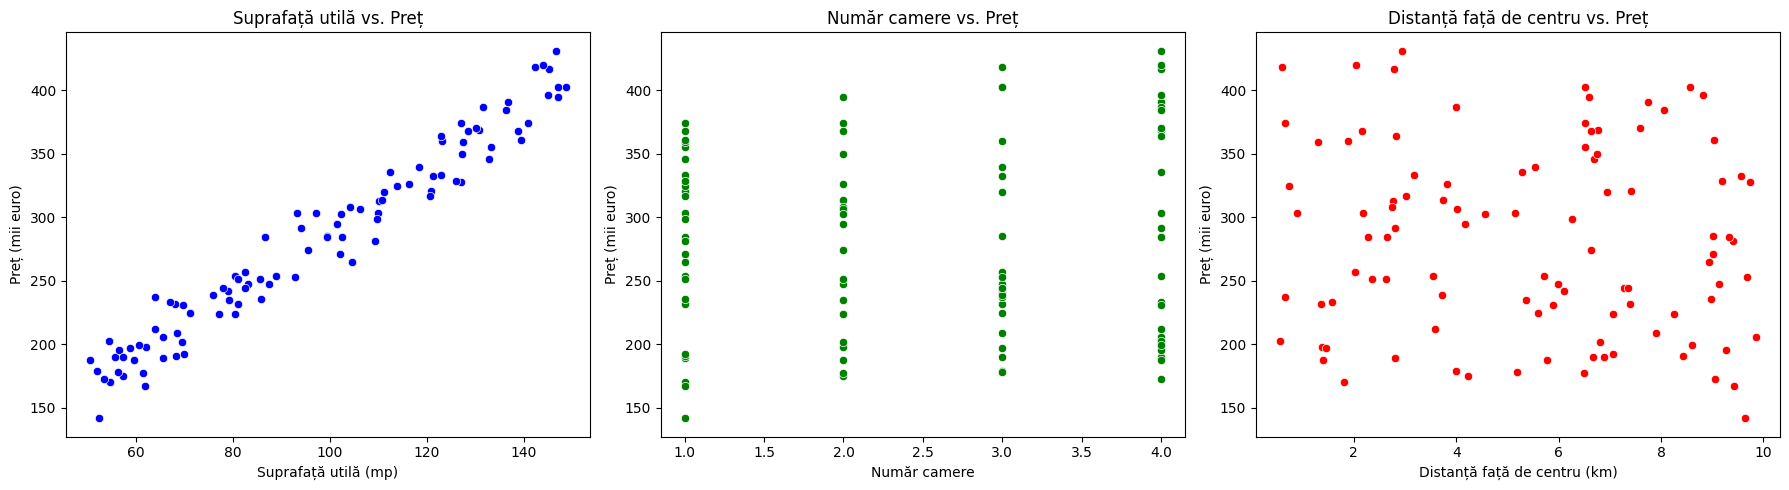

In [ ]:
# Denormalizarea coeficienților
std_x1 = np.std(x1)
std_x2 = np.std(x2)
std_x3 = np.std(x3)
std_y = np.std(y)

# Accesarea valorilor posteriori ale coeficientilor
beta1_posterior = trace.posterior['beta1'].values.flatten()  # Extragem valorile din posterior
beta2_posterior = trace.posterior['beta2'].values.flatten()
beta3_posterior = trace.posterior['beta3'].values.flatten()

# Calcularea coeficientilor denormalizați
beta1_denorm = beta1_posterior.mean() * (std_x1 / std_y)
beta2_denorm = beta2_posterior.mean() * (std_x2 / std_y)
beta3_denorm = beta3_posterior.mean() * (std_x3 / std_y)

# Denormalizarea interceptului
intercept_posterior = trace.posterior['intercept'].values.flatten()
intercept_denorm = intercept_posterior.mean() * std_y + y.mean() - (beta1_denorm * x1.mean()) - (beta2_denorm * x2.mean()) - (beta3_denorm * x3.mean())

# Vizualizare relații între variabile și preț
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(x=data['Surface_area'], y=data['Price'], ax=axs[0], color='blue')
axs[0].set_title("Suprafață utilă vs. Preț")
axs[0].set_xlabel("Suprafață utilă (mp)")
axs[0].set_ylabel("Preț (mii euro)")

sns.scatterplot(x=data['Rooms'], y=data['Price'], ax=axs[1], color='green')
axs[1].set_title("Număr camere vs. Preț")
axs[1].set_xlabel("Număr camere")
axs[1].set_ylabel("Preț (mii euro)")

sns.scatterplot(x=data['Distance_to_center'], y=data['Price'], ax=axs[2], color='red')
axs[2].set_title("Distanță față de centru vs. Preț")
axs[2].set_xlabel("Distanță față de centru (km)")
axs[2].set_ylabel("Preț (mii euro)")

plt.tight_layout()
plt.show()